# 単回帰分析

## 分析の手順
1. 使用するデータセットを確認する
2. データセットを加工する
3. 回帰式を求めることに意義があるか確認する
4. 回帰式を求める
5. 回帰式の精度
6. 回帰係数の検定

## 参考にする資料
- マンガでわかる統計学「回帰分析編」 高橋信 オーム社
- Pythonではじめる機械学習 オライリー・ジャパン
- http://www.randpy.tokyo/entry/2017/06/26/153800#fn-6a2f787c
- http://www.mwsoft.jp/programming/numpy/statsmodels_ols.html

---

## １．使用するデータセットの確認
取得元：https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

### 分析の目的
**単一の説明変数から目的変数（サービスの総利用者数）を予測する**

想定できるビジネス上の課題・施策
- 平均気温（最高気温や降水量でも）から販売個数をざっくりと予測したい（小売）

### 公開されていた情報
- アメリカのシェアサイクル（Capital Bikeshare）の履歴データ
- 会員登録していなくても利用することができる
- 天気情報は、http://www.freemeteo.com から取得している
- 対象の期間は、2011-01-01〜2012-12-31

### 想定できるビジネス上の考慮点
**収益面**
   - サービス提供している地域でイベントがあると利用者の大幅な増加が見込まれる
   - 広告としての役割を果たせる可能性がある

**コスト面**
   - 乗り捨て式の場合、利用者の多い場所への偏りが発生し、機会損失や自転車の再配置に伴うコストが発生する
   - 賃料（行政との連携があればそうでもないかも）、自転車と管理装置の保守費用がかかる
   - 地理的条件（坂の多さ、潮風）や地域性（犯罪発生数）に注意が必要

### データセットを目検して気づいたこと
- カテゴリカルデータは数値化されている
- 整っていて、目検で気になるデータはない

---

In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
# データのインポート
df_day = pd.read_csv('Bike_Sharing_Data_day.csv')
df_day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [3]:
# データ型の確認
df_day.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [4]:
# データ型の変換
df_day['dteday'] = df_day.dteday.map(lambda x: datetime.strptime(x,'%Y-%m-%d'))
df_day.describe(include='all')

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
unique,NaN,731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2012-02-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2011-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2012-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,366.000000,NaN,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,NaN,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,NaN,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,NaN,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000


### 気づいたこと
- 731日分の履歴データ
- 会員登録していない利用者に比べて、会員登録している利用者がかなり多い

---

## ２．データセットの加工

予測難易度を下げるため予め、好天候の日のみに絞る

In [5]:
# 晴れの日に限定し、分布と単相関係数を確認したいカラムを抽出する
df = df_day[df_day['weathersit'] == 1]
df_coef = df[['temp','atemp','hum','windspeed','casual','registered','cnt']]

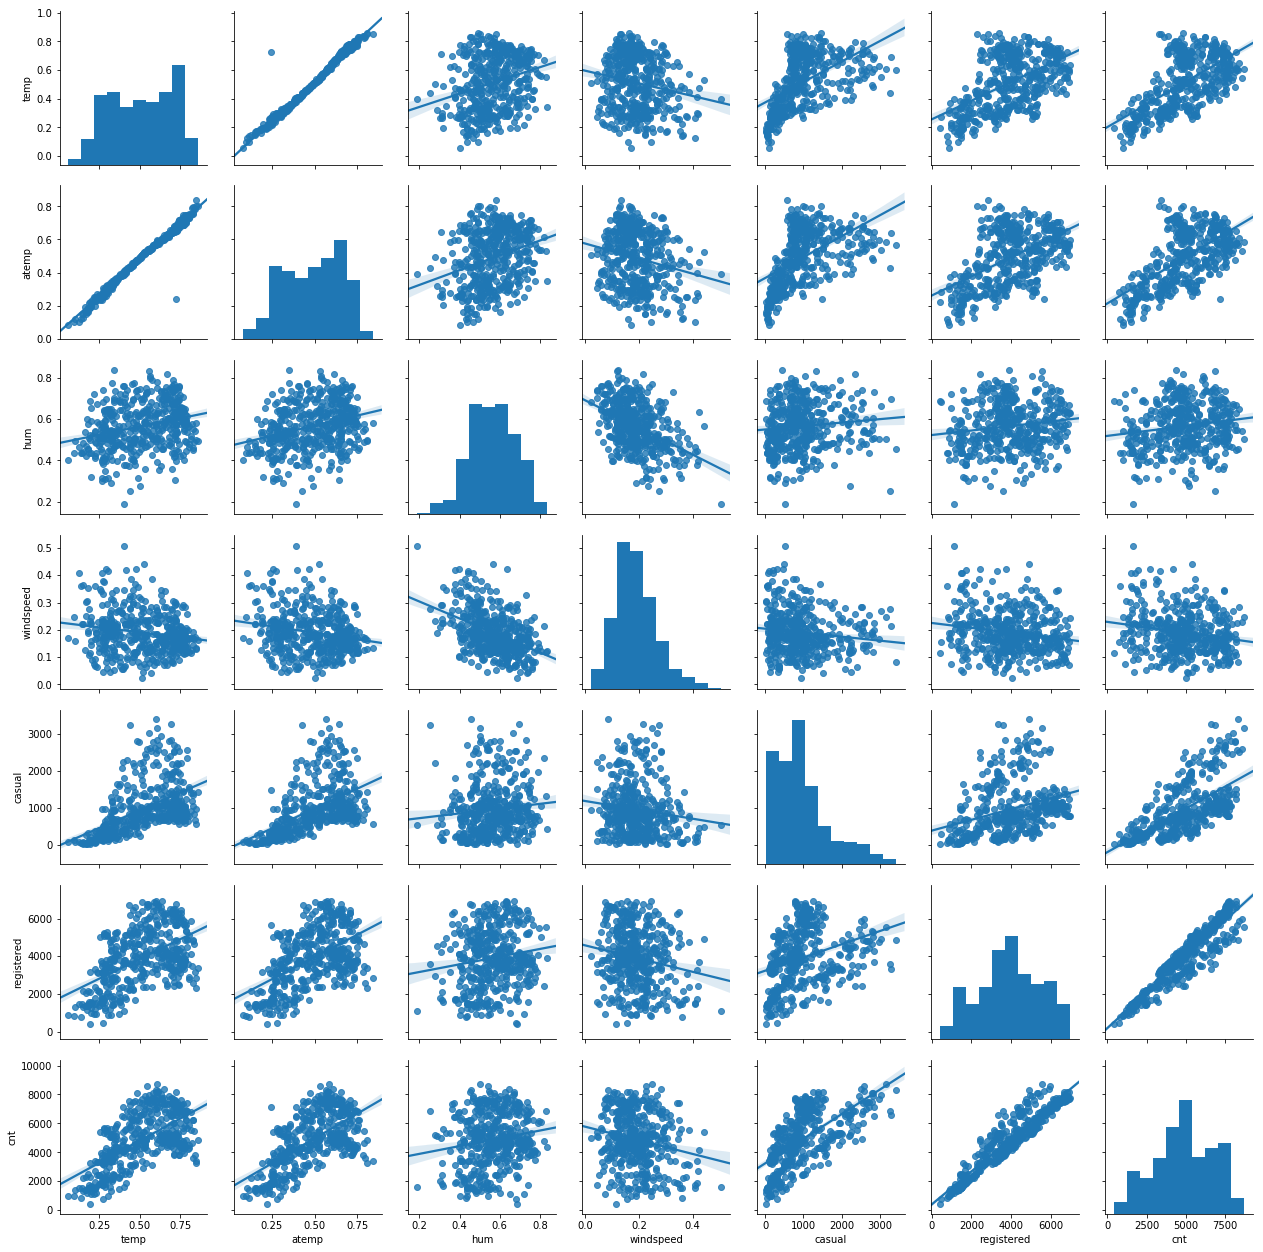

In [6]:
# 変数間の散布図と回帰直線を確認する
sns.pairplot(df_coef, kind="reg")

In [7]:
# 総利用数と各変数の単相関係数を確認する
col_name = df_coef.columns.values
for i in range(len(col_name)-1):
    x = df_coef[col_name[i]]
    y = df_coef['cnt']
    rxy = np.corrcoef(x,y)
    print("単相関係数:{}".format(rxy[0][1]), " :{}".format(col_name[i]))

単相関係数:0.6221904913438957  :temp
単相関係数:0.6235696560934256  :atemp
単相関係数:0.160751307645761  :hum
単相関係数:-0.1939408966961378  :windspeed
単相関係数:0.634990476344589  :casual
単相関係数:0.9356576444814501  :registered


標準化された気温(temp)、体感温度(temp)、非会員利用者(casual)は、サービス利用者とのやや強い関係性が認められる  
**想像に難くない結果だが、会員登録済み利用者数は、全体のサービス利用者との関係性が非常に強い**

---

## ３．回帰式を求めることに意義があるか確認する

**精度の高い回帰式を求めたいため、会員登録済み利用者から全体のサービス利用者を予測する回帰式を求める。**  
会員登録済み利用者を事前に把握できるシステムではない（完全予約制ではない）ため、ビジネス的な意義はない。

In [8]:
# 説明変数と目的変数のみを抽出
lr_df = df.loc[:,['registered','cnt']]
lr_df.head()

,registered,cnt
2,1229,1349
3,1454,1562
4,1518,1600
5,1518,1606
8,768,822


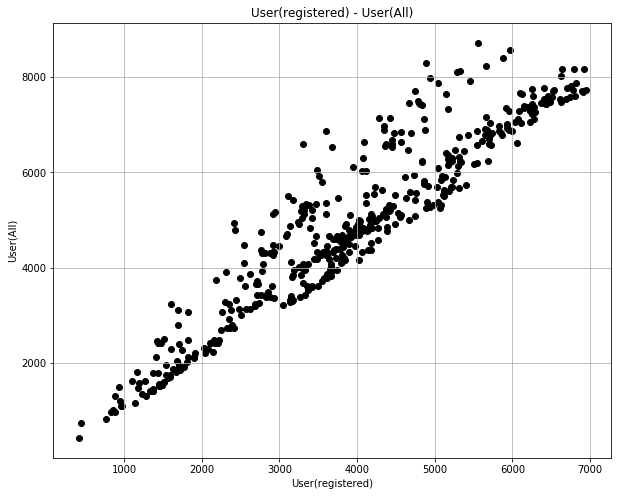

In [9]:
# 散布図を描画して、２変数の分布を確認
plt.figure(figsize=(10, 8))

x = lr_df['registered']
y = lr_df['cnt']
plt.scatter(x, y, c='black')

plt.title("User(registered) - User(All)")
plt.xlabel("User(registered)")
plt.ylabel("User(All)")
plt.grid(True)

In [10]:
# 単相関係数
np.corrcoef(x,y)[0][1]

0.93565764448145006

事前に確認した通り

---

## ４．回帰式を求める

In [11]:
# scikit-learnのLinearRegressionで回帰式を求める
lr = LinearRegression()

x = lr_df.loc[:,['registered']].as_matrix()
y = lr_df['cnt'].as_matrix()

lr.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

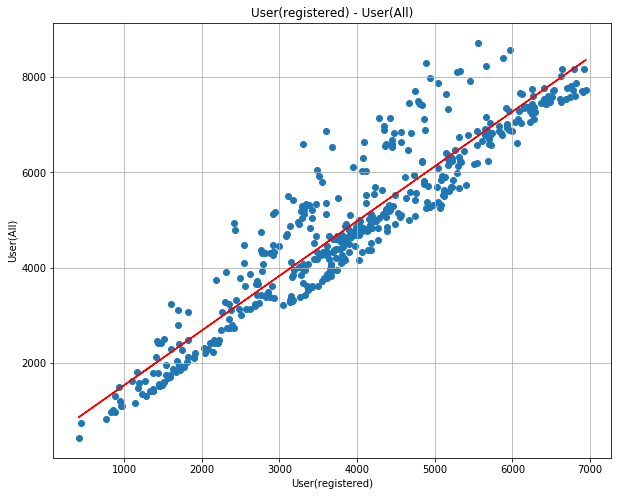

In [12]:
# 散布図と回帰直線をプロットする
plt.figure(figsize=(10, 8))

plt.scatter(x, y)
plt.plot(x, lr.predict(x), c='red')

plt.title("User(registered) - User(All)")
plt.xlabel("User(registered)")
plt.ylabel("User(All)")
plt.grid(True)

In [13]:
print("回帰係数:{}".format(lr.coef_[0]))
print("切片　　:{}".format(lr.intercept_))

回帰係数:1.146872337635713
切片　　:389.3546261449601


回帰式 $y=1.147x+389.35$ が求められた

---

## ５．回帰式の精度

In [14]:
print("決定係数(寄与率):{}".format(lr.score(x,y)))

決定係数(寄与率):0.8754552276765755


**決定係数(寄与率) $R^2$ が、1.0に近く精度は高い**

---

## ６．回帰係数の検定

scikit-learnのメソッドでは $P$ 値が算出されていないため、statsmodelsを使用する  
**有意水準は、0.05とする**

In [15]:
import statsmodels.api as smf

In [16]:
#　最小二乗法で回帰式を生成
x = lr_df['registered']
y = lr_df['cnt']

model = smf.OLS(y, smf.add_constant(x))

result = model.fit()

In [17]:
# 回帰係数と切片を取得
a, b = result.params
print("回帰係数:{}".format(b))
print("切片　　:{}".format(a))

回帰係数:1.1468723376357124
切片　　:389.35462614496294


scikit-learnで求めた回帰式と相違なく、回帰式 $y=1.147x+389.35$ が求められた。

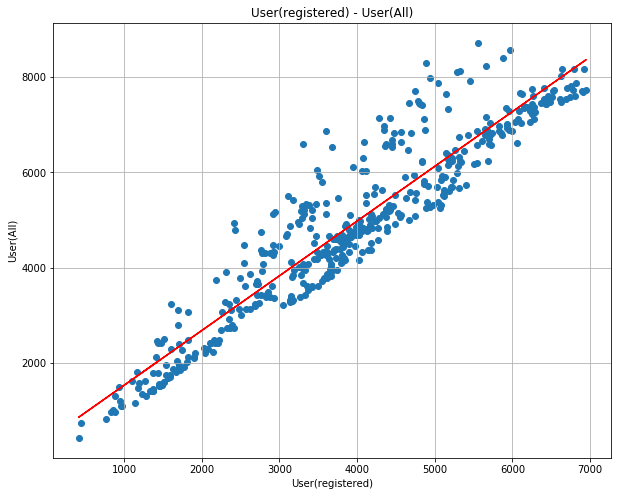

In [18]:
# 散布図と回帰直線をプロット
plt.figure(figsize=(10, 8))

plt.scatter(x, y)
plt.plot(x, a+b*x, color='red')

plt.title("User(registered) - User(All)")
plt.xlabel("User(registered)")
plt.ylabel("User(All)")
plt.grid(True)
plt.show()

In [19]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     3240.
Date:                Mon, 07 May 2018   Prob (F-statistic):          1.18e-210
Time:                        23:47:57   Log-Likelihood:                -3664.7
No. Observations:                 463   AIC:                             7333.
Df Residuals:                     461   BIC:                             7342.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        389.3546     84.655      4.599      0.000       222.997   555.712
registered     1.1469      0.020     56.925      0.000         1.107     1.186
==============================================================================
Omnibus:                      100.693   Durbin-Watson:                   1.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.329
Skew:                           1.347   Prob(JB):                     7.62e-37
Kurtosis:                       4.167   Cond. No.                     1.15e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**$P$ 値 ＜ 0.05 であることがわかった**  
統計的に有意である

---